# 1. 초기화
import lots of modules and set up filters regarding raw data

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import font_manager, rc

rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False   

column_filter = ['배송자휴대전화번호', 'T기프트배송자휴대전화번호', '주문번호', '주문일', '취소일', '결제일', '개통일', '배송일', '모델명', '가입유형', '약정프로그램', '요금제', '무약정Plan선택여부', 
                        '결제방법', '배송방법', '대리점', '주문유형', '쿠폰여부', '지인(추천인)코드', '개통일자', '센터명', '모바일구매여부', '상품구분(맞춤/패키지)', 
                        '서비스관리번호', 'TG상태값', '주문구분', '상담사소속', '대리점코드(중분류)', '외부유입경로', '약정구분', '포인트결제', '동의방법', 
                        '뉴보상기변 쓰던폰반납여부', '오늘보상 신청여부', '오늘보상 수거상태', '클럽기변 신청서 상태', 'T 갤럭시 클럽', '클럽기변 단말기할부금 면제금액', 
                        '대리점명', '매장명', 'D코드', '발송일']

# 개별 데이터를 상반부와 하반부를 합쳐서 생성

In [ ]:
# 기준이 되는 24일 ars 인입 고객 정보 로딩 - 나이 연령 정보 포함됨
customer_24 = pd.DataFrame(pd.read_csv('./access_nums_age_sex.csv'),columns=['전화번호', '나이', '성별'])
customer_24['나이'] = pd.to_numeric (customer_24['나이'], errors = 'coerce')
customer_24_drop_na = customer_24.dropna (axis=0)
index_names = customer_24_drop_na[ customer_24_drop_na['성별'] == '#' ].index

customer_24_drop_na.drop(index_names, inplace=True)
#display(customer_24_drop_na)

## 8월 24일 상담센터 인입고객 성별 비율 계산 및 시각화

In [69]:
## 24일 인입된 데이터에 대해서 성별로 정리해서 개수를 세도록 한다.
pivot_sex = pd.pivot_table(customer_24_drop_na, index="성별", values=['전화번호'], aggfunc='count')
display(pivot_sex)


,전화번호
성별,
남,5105
여,3438


<AxesSubplot:ylabel='전화번호'>

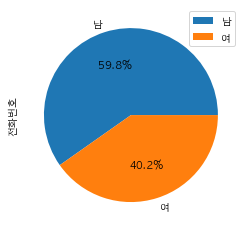

In [73]:
pivot_sex.plot.pie(y="전화번호", autopct='%1.1f%%')

### 위 차트 상으로 남자가 비중이 높다고 볼 수 있지만, 이 내용만으로 유의미한 결론이 나오지 않는다. 오히려, 성별과 나이대를 계산 hitmap을 그리도록 하자

In [70]:
## 히트맵 계산을 위해서, 나이대를 10 살 단위 기준으로 데이터를 정형화 하도록 한다.
## 이를 위해서 기존 데이터에 신규 칼럼 - "연령대" 을 추가하도록 하자.

age_band_width = 10
customer_24_drop_na['나이대'] = customer_24_drop_na['나이'].apply (lambda x: int(x/age_band_width) * age_band_width)
#customer_24_drop_na.head()

pivot_sex_age = pd.pivot_table(customer_24_drop_na, index="성별", columns = ["나이대"], values=['전화번호'], aggfunc='count')
display(pivot_sex_age)

/var/folders/ct/9_1289cs6777yd9wlsshrzxm0000gn/T/ipykernel_1034/4061808374.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_24_drop_na['나이대'] = customer_24_drop_na['나이'].apply (lambda x: int(x/age_band_width) * age_band_width)


전화번호                                                             
나이대   0     10      20      30      40     50     60    70    80   90
성별                                                                   
남    5.0  42.0  1058.0  1668.0  1382.0  660.0  219.0  62.0   9.0  NaN
여    5.0  21.0   760.0  1243.0   857.0  330.0  153.0  51.0  17.0  1.0

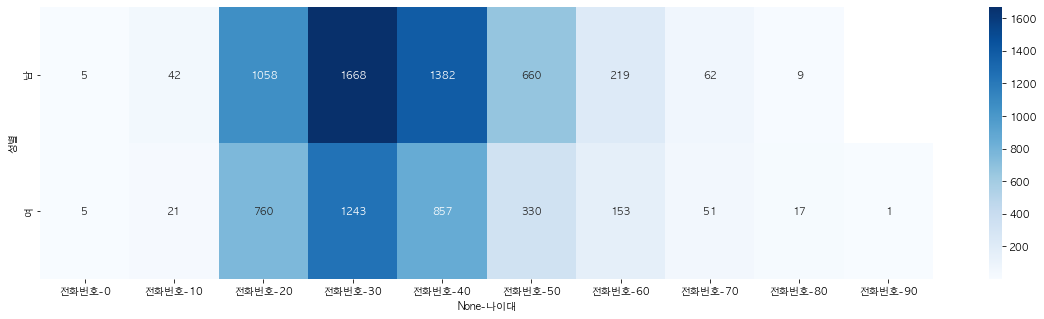

In [71]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('white')
 
sns.heatmap(pivot_sex_age, cmap='Blues', annot=True, fmt=".0f")
plt.show()

## 28일 하루 기준으로 상담센터에 전화를 한 고객의 나이 및 성별에 대해서는 다음과 같이 정리 가능
* 상대적으로 여자 보다 남자가 좀 더 전화를 통해서 예판 참여 후 상담센터에 전화를 걸었다.
* 분포 자체는 남성/여성 모두에 있어서 30대가 가장 높은 비중으로 전화로 연결을 많이 했다.

위와 같은 상담센터 이용에 있어서 성별, 나이별 차이는 현재 대상 데이터가 예판 대상 장비와 연관이 있어서, 일반적이지는 않다라고 판단이 가능.

# 실제 위 분포의 특이성을 확인하기 위해선, **전체 갤럭시 폴더블 예판 참가자 분포와 차이가 있는지 분석이 필요**

# 예판 시점에 상담센터에 전화를 한 고객 특성을 분석하자. 우리는 상담센터에 전화를 건 사람들이 가지고 있는 특성이 궁금하다. 
* 예를 들어서 어떤 특정 요금제를 사용하는 사람들인지 아니면 어떤 개통 상 특이 사항이 있는 고객들인지?
* 특정 가입 채널 분포가 더 높은지 이것도 아니면, 가입 단말이 특이 하던지?
* 이러한 관점들에 대해서 실제 데이터를 기준으로 검증을 해나가고자 한다.

# 관련 데이터 준비 단계 - 원 주문 데이터와 접근자 핸폰 정보를 하나로 구성

## 고객별 주문 데이터를 준비 - orders

In [ ]:
# 모바일 주문 정보 로딩 
mobile_order_1 = pd.DataFrame (pd.read_csv('./1_m.csv'), columns=column_filter)
mobile_order_2 = pd.DataFrame (pd.read_csv('./2_m.csv'), columns=column_filter)
mobile_orders = pd.concat([mobile_order_1, mobile_order_2], ignore_index=True, axis=0)
mobile_orders.reset_index(drop=True)

In [ ]:
# 바로픽업 정보들 로딩
pickup_order_1 = pd.DataFrame (pd.read_csv('./1_b.csv'), columns=column_filter)
pickup_order_2 = pd.DataFrame (pd.read_csv('./2_b.csv'), columns=column_filter)
pickup_orders = pd.concat([pickup_order_1, pickup_order_2], ignore_index=True, axis=0)
pickup_orders.reset_index(drop=True)

In [ ]:
# build up a merged dataframe that includes all data (mobile and pickup)

orders = pd.concat([mobile_orders, pickup_orders], ignore_index=True, axis=0)
display(orders)

## 고객 센터 인입 고객 데이터 준비 - accesslog